$\newcommand{\Ell}{\mathcal{L}}$
$\newcommand{\xdot}{\dot{x}}$
$\newcommand{\xddot}{\ddot{x}}$

# Lagrangian Mechanics via Machine Learning  
## ***Solving trajectories by minimizing the action with a neural network***  
Neural networks have been used to model physical systems by approximating solutions to differential equations. In classical physics, such equations can be derived from Newtonian mechanics to describe trajectories. A fundamentally different approach can be taken through Lagrangian Mechanics, which formulate the problem as finding the path that minimizes[$^1$](#Footnotes) a quantity, the action. Then, the solution can be found by minimizing the action with supervised learning.


## Lagrangian Mechanics

Newton's laws formulate classical mechanics as solving differential equations. The forces in the problem are summed and related to the acceleration[$^2$](#Footnotes). The position as a function of time is obtained by integrating the acceleration twice.

<!-- : $F=m\xddot$, where the forces typically depend on x or its time derivative $\xdot\equiv\frac{dx}{dt}$. -->

An alternate approach is Lagrangian mechanics, where the trajectories of objects are defined as *stationary* paths of the action. Stationary paths imply the action is at a minimum, maximum, or saddlepoint with respect to small deviations of the trajectory $x(t)$. In classical mechanics, stationary maxima do not exist, and sufficiently short paths are minima ([Gray and Taylor, 2007](https://pubs.aip.org/aapt/ajp/article-abstract/75/5/434/1041968/When-action-is-not-least)). Consequently, this stationary action principle is often called the principle of *least* action despite the slight inaccuracy. With some work, Lagrangian mechanics can be shown to be equivalent to Newtonian mechanics.

The action, S, is defined as $S\equiv\int_{t_0}^{t_f} \Ell dt$, with $\Ell$ being the particular Lagrangian that describes the system. The Lagrangian, in turn, is simply $\Ell\equiv T-U$, for the kinetic energy $T$ and potential energy $U$ of the system[$^3$](#Footnotes). This conveniently defines the system through scalar quantities (the energies) instead of vectors (summed forces). Note that the stationary action principle requires initial and final values for both position and time to be specified, but not initial velocity.

![this](./Feynman_paths.png "Sachin48 sps, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons")
*Sachin48 sps, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons*

## Using ML
To find an action-minimizing trajectory with machine learning, we must
1. Define a network architecture
2. Specify and compute a loss quantity
3. Add initial constraints

### Network architecture
The neural network has one input node (for time) and one output node to act as a 1D function. General approximation can be achieved with a standard mix of fully connected layers and ReLU activations as hidden layers.

We could choose to approximate the position as a function of time, $x(t)$, with the neural network. The action depends on the velocity, $\xdot(t)$ (where a dot represents a time derivative), and this can be computed through automatic differentiation of the network. However, the derivative of the ReLU activation layers are just step functions. Such a network would only be capable of stitching together segments of constant velocity[$^4$](#Footnotes). Instead, it is more convenient to have the network approximate $\xdot(t)$ and to obtain the position through numeric integration.

### Adding initial constraints
The next step is to impose the boundary conditions on the trajectories. In many physics-informed neural networks ([PINNs](https://www.sciencedirect.com/science/article/pii/S0021999118307125)), a second loss term penalizes deviations from the boundary conditions for solving the PDE. For our 1D problem, there's an elegant solution. We can transform the output of the neural network to obey the boundary conditions by construction.

Let $x(t)$ be the position function, which depends on the neural network output $n(t)$ and must satisfy the boundary conditions are $x(t_i)=q_i$ and $x(t_f)=q_f$ for initial and final times $t_i$ and $t_f$.
Then we let  
$x(t)=n(t)-n(t_i)+(t-t_i)C+q_i$ and therefore  
$\xdot(t)=\dot{n}(t)+C$  
for $C=\frac{q_f-q_i - (n(t_f)-n(t_i))}{t_f-t_i}$. It is easily verified that $x(t)$ obeys both boundary conditions regardless of $n(t)$. Heuristically, $C$ corrects the average velocity to match the average velocity given by the boundary conditions, and $q_i$ is included as the constant of integration.

### Computing the action as loss
The action for a particular path can be computed numerically. First, sample timesteps from the time interval to act as input data. Evaluate the neural network on the points to get the velocity, then integrate the velocity with the trapezoid rule to get position values. Then the Lagrangian can be evaluated for each point, and integrated to obtain the action.

### Training Loop
Putting it all together, the training loop consists of sampling a set of points, evaluating the neural network, transforming the output to obey the boundary conditions, computing the action, and then taking the action as the loss and backpropagating. In Pytorch, it looks like

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
import pdb
from collections import namedtuple

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        N = 128
        self.N = N
        self.stack = nn.Sequential(
                nn.Linear(1,N),
                nn.ReLU(),
                nn.Linear(N,N),
                nn.ReLU(),
                nn.Linear(N//1,1)
        )

    def forward(self,x):
        return self.stack(x)

def trainNN(Lagrangian,parameters):
    
    NN = NeuralNetwork()
    optimizer = torch.optim.Adam(NN.parameters(),lr=1e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=400, threshold=0.0001, threshold_mode='abs',eps=1e-15,cooldown=100)
    losses = []

    paths = namedtuple("Paths","t q qdot L H NNq NNqdot")
    paths.t = []
    paths.q = []
    paths.qdot = []
    paths.L = []
    paths.H = []
    paths.NNq = []
    paths.NNqdot = []


    epochs=500
    Npoints=2**8
    NN.train()
    for i in range(epochs):
        optimizer.zero_grad()

        timesteps = torch.cat([torch.tensor(params.ti,dtype=torch.float).reshape(-1,1),
            torch.FloatTensor(Npoints-2,1).uniform_(params.ti,params.tf),
            torch.tensor(params.tf,dtype=torch.float).reshape(-1,1)])
        timesteps = timesteps.sort(dim=0)[0] #sorted for trap rule

        NNqdot = NN(timesteps)
        NNq = torch.cat([ torch.zeros((1,1)),  torch.cumulative_trapezoid(NNqdot,x=timesteps,dim=0) ])

 

        C = ((params.qf-params.qi) - (NNq[-1]-NNq[0]))/(params.tf-params.ti)

        # add constant to NNqdot to make qdot match avg displacement; offset q
        qdot = NNqdot+C
        q = NNq+(C*timesteps-C*timesteps[0])+params.qi


        L = Lagrangian(q,qdot,params)
        H = params.m*qdot**2-L

        action = torch.trapezoid(L,x=timesteps,dim=0)
        loss = action
        loss.backward()

        optimizer.step()
        scheduler.step(loss)
        optimizer.zero_grad()

#         if i%50==0:
#             print("{}\taction {:.4f},  lr {:.2E}".format(i,loss.item(),scheduler._last_lr[0]))
        losses.append(loss.item())

        if (i%(100)==0 and i>100) or i+1==epochs:
            paths.t.append( timesteps.T.tolist()[0])
            paths.q.append(q.T.tolist()[0])
            paths.qdot.append(qdot.T.tolist()[0])
            paths.L.append(L.T.tolist()[0])
            paths.H.append(H.T.tolist()[0])
            paths.NNq.append(NNq.T.tolist()[0])
            paths.NNqdot.append(NNqdot.T.tolist()[0])
    return NN,paths,losses


## Example: Linear Potential (Local Gravity): $\Ell=\frac{1}{2}m\xdot^2+mg\xdot$

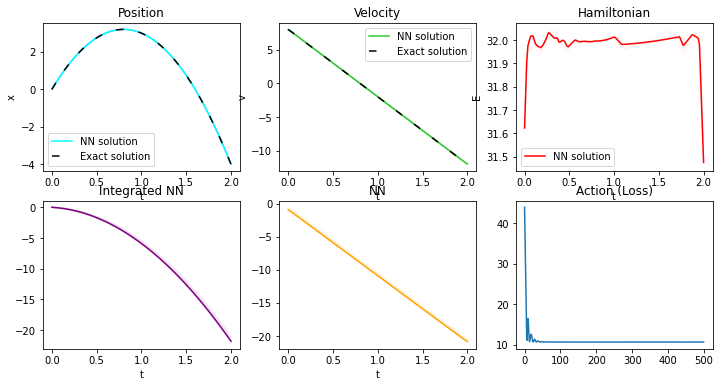

In [2]:
params = namedtuple("Parameters","ti tf qi qf k m")
params.ti = 0
params.tf = 2
params.qi = 0
params.qf = -4
params.g = -10
params.m = 1

def LinearPotential(q,qdot,params):
    return 1/2*params.m*qdot**2 + params.m*params.g*q

model,paths,losses = trainNN(LinearPotential,params)
v0=(params.qf-params.qi)/(params.tf-params.ti)-params.g/2*(params.tf-params.ti)


fig, axs = plt.subplots(2,3)
plt.rcParams['figure.constrained_layout.use'] = True
axs[0,0].set_title("Position")
for i,(t,path) in enumerate(zip(paths.t,paths.q)):
    axs[0,0].plot(t,path,color="blue",alpha=0.1)

axs[0,0].plot(t,path,color="cyan",alpha=1,label="NN solution")
axs[0,0].plot(t,[0.5*params.g*ts**2+v0*ts+params.qi for ts in t],color="black",linestyle=(0,(5, 10)),label="Exact solution")

axs[0,0].set_xlabel("t")
axs[0,0].set_ylabel("x")
axs[0,0].legend()

axs[0,1].set_title("Velocity")
for i,(t,path) in enumerate(zip(paths.t,paths.qdot)):
    axs[0,1].plot(t,path,color="darkgreen",alpha=0.1)

axs[0,1].plot(t,path,color="limegreen",alpha=1,label="NN solution")
axs[0,1].plot(t,[params.g*ts+v0 for ts in t],color="black",linestyle=(0,(5, 10)),label="Exact solution")

axs[0,1].set_xlabel("t")
axs[0,1].set_ylabel("v")
axs[0,1].legend()

axs[0,2].set_title("Hamiltonian")
for i,(t,path) in enumerate(zip(paths.t,paths.H)):
    axs[0,2].plot(t,path,color="pink",alpha=0.1)
axs[0,2].plot(t,path,color="red",alpha=1,label="NN solution")
axs[0,2].set_xlabel("t")
axs[0,2].set_ylabel("E")
axs[0,2].legend()

axs[1,0].set_title("Integrated NN")
axs[1,1].set_title("NN")
axs[1,2].set_title("Action (Loss)")

for i,(t,path) in enumerate(zip(paths.t,paths.NNq)):
    axs[1,0].plot(t,path,color="purple",alpha=0.1)
axs[1,0].plot(t,path,color="purple",alpha=1)
axs[1,0].set_xlabel("t")

for i,(t,path) in enumerate(zip(paths.t,paths.NNqdot)):
    axs[1,1].plot(t,path,color="orange",alpha=0.1)
axs[1,1].plot(t,path,color="orange",alpha=1)
axs[1,1].set_xlabel("t")

axs[1,2].plot(losses)
plt.show()


The neural network's solution matches the theory (dashed lines) in position and velocity. Additionally, the Hamiltonian of the system, which equates to the total energy for most systems, can be computed from the numerical Lagrangian. The flatness of the plot over time can be taken as further validation of the solution (especially neglecting the endpoints which pose problems for the numerical integration). 

## Harmonic Oscillator (Spring): $\Ell=\frac{1}{2}m\xdot^2-\frac{1}{2}k\xdot^2$

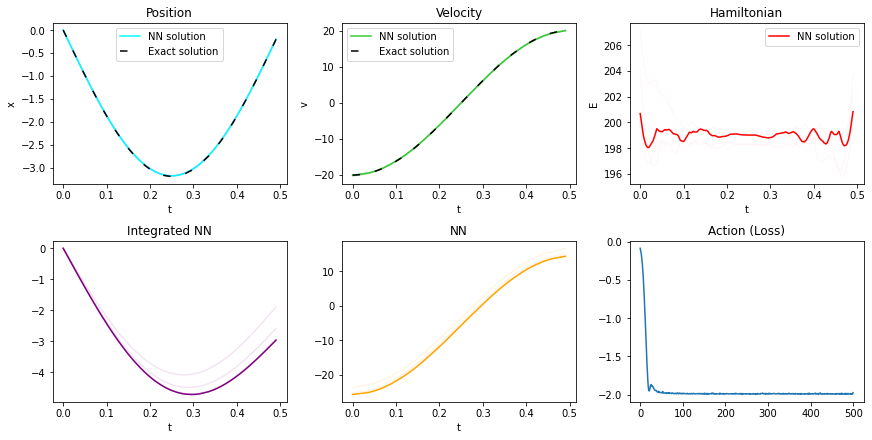

In [33]:
params = namedtuple("Parameters","ti tf qi qf k m")
params.ti = 0
params.tf = 0.49
params.qi = 0
params.qf = -.2
params.k = (6.2832)**2
params.m = 1

def HarmonicOscillator(q,qdot,params):
    #return 1/2*m*qdot**2 - m*g*q
    return 1/2*params.m*qdot**2 - 1/2*params.k*q**2

model,paths,losses = trainNN(HarmonicOscillator,params)
#analytic formula
w = (params.k/params.m)**0.5
v0= params.qf*w/np.sin(w*params.tf)
E = 1/2*params.m*v0**2
A = v0/w

fig, axs = plt.subplots(2,3)
plt.rcParams['figure.constrained_layout.use'] = True
axs[0,0].set_title("Position")
for i,(t,path) in enumerate(zip(paths.t,paths.q)):
    axs[0,0].plot(t,path,color="blue",alpha=0.1)

axs[0,0].plot(t,path,color="cyan",alpha=1,label="NN solution")

axs[0,0].plot(t,[A*np.sin(w*ts) for ts in t],color="black",linestyle=(0,(5, 10)),label="Exact solution")
axs[0,0].set_xlabel("t")
axs[0,0].set_ylabel("x")
axs[0,0].legend()

axs[0,1].set_title("Velocity")
for i,(t,path) in enumerate(zip(paths.t,paths.qdot)):
    axs[0,1].plot(t,path,color="darkgreen",alpha=0.1)

axs[0,1].plot(t,path,color="limegreen",alpha=1,label="NN solution")

axs[0,1].plot(t,[A*w*np.cos(w*ts) for ts in t],color="black",linestyle=(0,(5, 10)),label="Exact solution")
axs[0,1].set_xlabel("t")
axs[0,1].set_ylabel("v")
axs[0,1].legend()

axs[0,2].set_title("Hamiltonian")
for i,(t,path) in enumerate(zip(paths.t,paths.H)):
    axs[0,2].plot(t,path,color="pink",alpha=0.1)
axs[0,2].plot(t,path,color="red",alpha=1,label="NN solution")
axs[0,2].set_xlabel("t")
axs[0,2].set_ylabel("E")
axs[0,2].legend()

axs[1,0].set_title("Integrated NN")
axs[1,1].set_title("NN")
axs[1,2].set_title("Action (Loss)")

for i,(t,path) in enumerate(zip(paths.t,paths.NNq)):
    axs[1,0].plot(t,path,color="purple",alpha=0.1)
axs[1,0].plot(t,path,color="purple",alpha=1)
axs[1,0].set_xlabel("t")

for i,(t,path) in enumerate(zip(paths.t,paths.NNqdot)):
    axs[1,1].plot(t,path,color="orange",alpha=0.1)
axs[1,1].plot(t,path,color="orange",alpha=1)
axs[1,1].set_xlabel("t")

axs[1,2].plot(losses)
plt.show()


The harmonic oscillator presents much more of a challenge. The analytic solution is a sine wave with a period set by the spring constant $k$ and object's mass $m$. The neural network will find the correct solution for time intervals below half a period. Durations longer than half a period lead to saddlepoints of the action, not minima [$^5$](#Footnotes). Consequently, the neural network will not converge to a solution. 

The issue is more clear when considering a path going exactly half a period. All trajectories starting at the origin, no matter the initial velocity, return to the origin after half a period. The boundary conditions we imposed do not select a unique path, so the action-minimizing approach is bound to fail.
![sines](sines.png)
This highlights the role of boundary conditions in differential equations. Newtonian mechanics specifies the function and its derivative at a point, and these Cauchy conditions guarantee the existence and uniqueness of solutions for broad classes of ordinary differential equations. No such luck is had with the Dirichlet conditions of fixed boundaries. The problems here derive not from the training approach but the underlying mathematics.

Earlier, it was claimed that Lagrangian mechanics was equivalent to Netwonian mechanics, and the above discussion may seem to invalidate that. But the stationary action principle can be used to derive the Euler-Lagrange (E-L) equation,  
$\frac{\partial\Ell}{\partial q}=\frac{\mathrm{d}}{\mathrm{dt}} \left(\frac{\partial\Ell}{\partial \dot{q}}\right)$.  
Functions satisfying the above differential equation necessarily obey the stationary action principle. Loosely, the E-L equation minimizes the action on infinitessimal sections on which Dirichlet conditions are (to first order) equivalent to Cauchy conditions. As this exercise was started to avoid solving differential equations, we'll consider other approaches to the stationary action's uniqueness problem.

Other tries:
-Hamiltonian-type approach, minimize std(H) specifying f'(0)
-Stationary action, but point-by-point? Eh, still first derivitive problem
-Can the endpoint be replaced by the derivative? local conservation of energy term? but that's just hamiltonian
-Stationary action with initial constraints? https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.110.174301 and https://arxiv.org/pdf/1412.3082 https://www.sciencedirect.com/science/article/pii/S0021999123000372?via%3Dihub


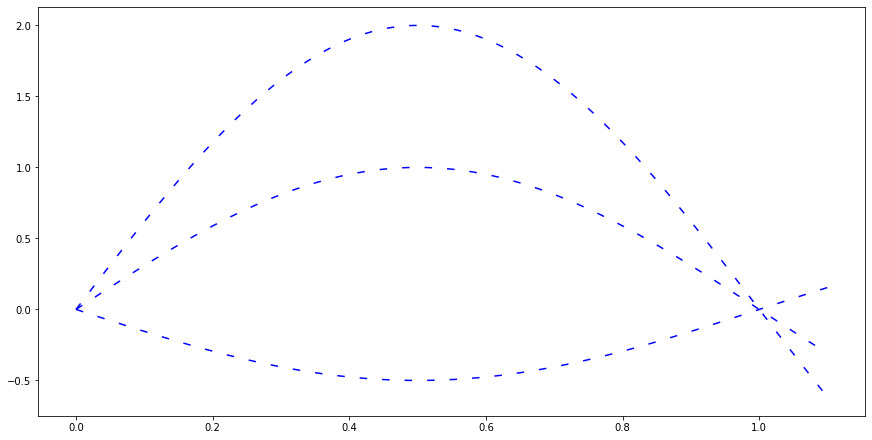

In [40]:
t=np.linspace(0,1.1,num=100)
plt.plot(t,np.sin(np.pi*t),color="blue",linestyle=(0,(5, 10)))
plt.plot(t,2*np.sin(np.pi*t),color="blue",linestyle=(0,(5, 10)))
plt.plot(t,-0.5*np.sin(np.pi*t),color="blue",linestyle=(0,(5, 10)))
plt.savefig("sines.png")

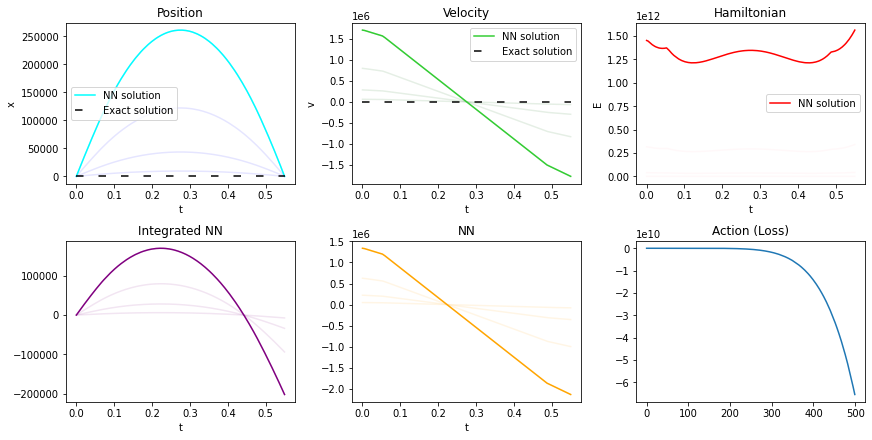

In [19]:
params = namedtuple("Parameters","ti tf qi qf k m")
params.ti = 0
params.tf = 0.55
params.qi = 0
params.qf = 0.1
params.k = (6.2832)**2
params.m = 1

def HarmonicOscillator(q,qdot,params):
    #return 1/2*m*qdot**2 - m*g*q
    return 1/2*params.m*qdot**2 - 1/2*params.k*q**2

model,paths,losses = trainNN(HarmonicOscillator,params)
#analytic formula
w = (params.k/params.m)**0.5
v0= params.qf*w/np.sin(w*params.tf)
E = 1/2*params.m*v0**2
A = v0/w

fig, axs = plt.subplots(2,3)
plt.rcParams['figure.constrained_layout.use'] = True
axs[0,0].set_title("Position")
for i,(t,path) in enumerate(zip(paths.t,paths.q)):
    axs[0,0].plot(t,path,color="blue",alpha=0.1)

axs[0,0].plot(t,path,color="cyan",alpha=1,label="NN solution")

axs[0,0].plot(t,[A*np.sin(w*ts) for ts in t],color="black",linestyle=(0,(5, 10)),label="Exact solution")
axs[0,0].set_xlabel("t")
axs[0,0].set_ylabel("x")
axs[0,0].legend()

axs[0,1].set_title("Velocity")
for i,(t,path) in enumerate(zip(paths.t,paths.qdot)):
    axs[0,1].plot(t,path,color="darkgreen",alpha=0.1)

axs[0,1].plot(t,path,color="limegreen",alpha=1,label="NN solution")

axs[0,1].plot(t,[A*w*np.cos(w*ts) for ts in t],color="black",linestyle=(0,(5, 10)),label="Exact solution")
axs[0,1].set_xlabel("t")
axs[0,1].set_ylabel("v")
axs[0,1].legend()

axs[0,2].set_title("Hamiltonian")
for i,(t,path) in enumerate(zip(paths.t,paths.H)):
    axs[0,2].plot(t,path,color="pink",alpha=0.1)
axs[0,2].plot(t,path,color="red",alpha=1,label="NN solution")
axs[0,2].set_xlabel("t")
axs[0,2].set_ylabel("E")
axs[0,2].legend()

axs[1,0].set_title("Integrated NN")
axs[1,1].set_title("NN")
axs[1,2].set_title("Action (Loss)")

for i,(t,path) in enumerate(zip(paths.t,paths.NNq)):
    axs[1,0].plot(t,path,color="purple",alpha=0.1)
axs[1,0].plot(t,path,color="purple",alpha=1)
axs[1,0].set_xlabel("t")

for i,(t,path) in enumerate(zip(paths.t,paths.NNqdot)):
    axs[1,1].plot(t,path,color="orange",alpha=0.1)
axs[1,1].plot(t,path,color="orange",alpha=1)
axs[1,1].set_xlabel("t")

axs[1,2].plot(losses)
plt.show()


#Save for boundary condition discussion

# Machine Learning with Action
## Can neural networks learn phyical trajectories from Lagrangian mechanics? 
Neural networks have been used to model physical systems by solving differential equations. When the problem can be formulated as minimizing a quantity over a trajectory, such as Lagrangian mechanics, neural networks can find solutions.
[PINN](https://www.sciencedirect.com/science/article/pii/S0021999118307125)


## Lagrangian Mechanics

Newton's laws formulate classical mechanics as solving differential equations: $F=m\xddot$, where the forces typically depend on x or its time derivative $\xdot\equiv\frac{dx}{dt}$.

An alternate approach is Lagrangian mechanics, where the trajectories of objects are *stationary* paths of the action, $S\equiv\int_{t_0}^{t_f} \Ell dt$, with $\Ell$ being the Lagrangian that describes the system. Stationary paths imply the action is at a minimum, maximum, or saddlepoint with respect to small deviations of the trajectory $x(t)$. In classical mechanics, stationary maxima do not exist, and sufficiently short paths are minima ([Gray and Taylor, 2007](https://pubs.aip.org/aapt/ajp/article-abstract/75/5/434/1041968/When-action-is-not-least)). Consequently, this principle of stationary action is often called the principle of *least* action despite the slight inaccuracy. 

The action is rarely worked with directly. Stationary paths can be shown to obey the differential Euler-Lagrange equations, 

The Euler-Lagrange equations 

The Lagrangian is the difference in kinetic (T) and potential (U) energy: $\Ell=T-U$.
$%It is linked to the Hamiltonian through a Legendre transformation L(q,\dot{q}) = m\ddot{q}^2-H $

## ML Structure
Formulation:
1. Sample points from the time interval
2. Evaluate NN on each point
3. Compute action from NN evaluation

## On Boundary Conditions


The Lagrangian does not wholly define the trajectory. Boundary conditions are needed to enforce the trajectory starts and ends at the specified locations. While one common approach is to add a loss term to the training to penalize discrepancies, in this case the boundary conditions can be imposed by construction.

Given some learned function $g(t)$ and its derivative $g'(t)$, we can define $f'(t)=g'(t)+C$ and $f(t)=g(t)+C*(t_f-t_i)+D$, where $C=\frac{q_f-q_i-(g(t_f)-g(t_i)}{t_f-t_i}$ and $D=f(t_f)$. C sets the trajectory's average velocity to match that of the specified conditions and D fixes the initial position.



The principle of stationary action uses Dirichlet boundary conditions, where a function's value is specified at two points, e.g. the start and end of the trajectory. This differs from Cauchy boundary conditions that specify a function and its derivative at a particular point, e.g. the object's location and initial velocity. Cauchy conditions imply existence and uniqueness theorems for ordinary differential equations under reasonable assumptions. Dirichlet conditions can have multiple or no solutions even in simple cases.

For example, consider a mass on a spring (harmonic oscillator). Specifying an object's initial position and velocity uniquely determine the trajectory. But all possible trajectories cross at the origin every half period. If Dirichlet conditions define two points half a period (or multiples thereof) away, there are either infinite solutions (if the specified positions are equal) or none (if they differ). 


$%Analytically, one can use the principle of stationary action to derive the Euler-Lagrange differential equations that then use Cauchy boundary conditions. Heuristically, the principle of stationary action is applied on infinitessimal spaces, so that the function's derivative is enough to specify the endpoint.$



## My notes
### Linear potential 
-Easy due to guaranteed minimum and specified exactly by start&finish

### Harmonic Oscillator
Tough from constraints
- Infinite paths if q_i=q_f and N periods apart
- No paths if q_i!=q_f and N periods apart
- switch between positive&negative paths when cross

Works if under half a period, otherwise need to specify energy
- Splice together solution?

Conservation of energy slightly better, but still pitfalls:
- Many periods: hit one peak then stay at T=0,U=E until decay, or flip between positive and negative solutions

[Nature's Cost Function](https://arxiv.org/pdf/2303.02115)


## Footnotes
$^1$: More properly, stationary paths of the action, including saddle points  
$^2$: Technically, $F=\frac{dp}{dt}$ which gives $F=ma$ as long as mass isn't changing  
$^3$: Lagrangians outside classical mechanics can take much more complicated forms.  
$^4$: This should be avoidable with a different activation function. Using the integral of the ReLU activation has been proposed as one solution ([Lo and Huang](https://arxiv.org/abs/2310.01649)).  
$^5$: This is related to how trajectories for different initial velocities cross at the half period timestep. See the Gray and Taylor paper for details.  
[PINN](https://www.sciencedirect.com/science/article/pii/S0021999118307125)
